In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import pandas as pd
from torch import nn 
import numpy as np



/home/delgerskhn/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
train_df = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_df = pd.read_csv('../data/kaggle_house_pred_test.csv')


In [3]:
all_features = pd.concat((train_df.iloc[:, 1:-1], test_df.iloc[:, 1:]))

In [4]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [5]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [6]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean())/(x.std()))

In [7]:
#Filling not given values by it's feature mean is convenient for processing
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## One hot encoding

In [8]:
all_features= pd.get_dummies(all_features, dummy_na=True)
all_features.shape


(2919, 331)

## from pandas extract numpy and convert to tensors 

In [9]:
n_train = train_df.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_label = torch.tensor(
        train_df.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [10]:
n_train, train_features, test_features, train_label

(1460,
 tensor([[ 0.0673, -0.1844, -0.2178,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735,  0.4581, -0.0720,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.0673, -0.0559,  0.1372,  ...,  1.0000,  0.0000,  0.0000],
         ...,
         [ 0.3025, -0.1416, -0.1428,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735, -0.0559, -0.0572,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735,  0.2439, -0.0293,  ...,  1.0000,  0.0000,  0.0000]]),
 tensor([[-0.8735,  0.4581,  0.1843,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735,  0.5009,  0.5197,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.0673,  0.2011,  0.4643,  ...,  1.0000,  0.0000,  0.0000],
         ...,
         [-0.8735,  3.8850,  1.2466,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.6553, -0.3130,  0.0346,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.0673,  0.2011, -0.0686,  ...,  1.0000,  0.0000,  0.0000]]),
 tensor([[208500.],
         [181500.],
         [223500.],
         ...,
         [266500.],
         [14212

## Initialize model parameters

In [11]:
num_inputs, num_hiddens, num_outputs = 331, 165, 1


## Training

In [12]:
loss = nn.MSELoss()
def get_net():
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs,num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, 1)
    )
    return net


In [13]:
def log_rmse(net, features, labels):#log root mse
    #to stabilzie the log value, set the value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
             num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    #The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K-Fold cross validation

In [15]:
def get_k_fold_data(k, i, X, y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train= torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
          batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data=get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0 :
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                    xlabel='epoch', ylabel = 'rmse', xlim=[1, num_epochs],
                    legend=['train', 'valid'], yscale='log')
        print(f'fold {i+1}, train log rmse{float(train_ls[-1]):f}, '
             f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum/k, valid_l_sum/k

## Model selection

fold 1, train log rmse0.123672, valid log rmse 0.168671
fold 2, train log rmse0.083765, valid log rmse 0.166509
fold 3, train log rmse0.053076, valid log rmse 0.166031
fold 4, train log rmse0.053212, valid log rmse 0.135458
fold 5, train log rmse0.067320, valid log rmse 0.165226
5-fold validation: avg train log rmse: 0.076209, avg valid log rmse: 0.160379


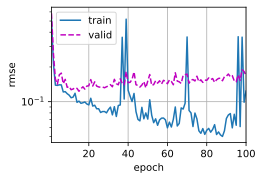

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_label, num_epochs, lr, 
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [20]:
def train_and_pred(train_features,test_feature, train_labels, test_data,
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                       num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls],
            xlabel='epoch',
            ylabel='log rmse',
            xlim=[1, num_epochs],
            yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set 
    preds = net(test_features).detach().numpy()
    #Reformat it to export to Kaggle
    test_df['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_df['Id'], test_df['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.046139


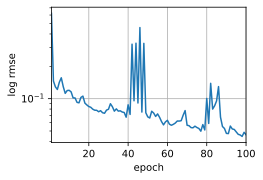

In [21]:
train_and_pred(train_features, test_features, train_label, test_df, 
               num_epochs, lr, weight_decay, batch_size)